In [264]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
from tqdm import tqdm
from scipy.stats import lognorm

# Q1

In [265]:
def resolutionSystem1Euler(alpha,beta,delta,gamma,y0,z0,dt,N,t0=1900.0):
    "Cette fonctipn permet de resoudre le système (1)"
    temps = np.arange(0,N)*dt+t0 # si j'ai bien compris la question (dt=10/(N-1) pour 10 années)
    y = [y0]
    z = [z0]
    for i in range(N-1):
        y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
        z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))

    return temps,np.array(y,dtype=np.float64),np.array(z,dtype=np.float64)

In [266]:
def h(y,z,alpha,beta,delta,gamma) :
    # print(y.dtype)
    # print(z.dtype)
    # print(y*(alpha-beta*z),z*(delta*y-gamma))
    return y*(alpha-beta*z),z*(delta*y-gamma)

In [267]:
def resolutionSystem1EulerRK4(alpha,beta,delta,gamma,y0,z0,dt,N,t0=1900.0):
    "Cette fonctipn permet de resoudre le système (1)"
    temps = np.arange(0,N)*dt+t0 # si j'ai bien compris la question (dt=10/(N-1) pour 10 années)
    y = [y0]
    z = [z0]
    for i in range(N-1):
        k1 = h(y[i],z[i],alpha,beta,delta,gamma)
        k2 = h(y[i]+0.5*dt*k1[0],z[i]+0.5*dt*k1[1],alpha,beta,delta,gamma)
        k3 = h(y[i]+0.5*dt*k2[0],z[i]+0.5*dt*k2[1],alpha,beta,delta,gamma)
        k4 = h(y[i]+dt*k3[0],z[i]+dt*k3[1],alpha,beta,delta,gamma)
        y.append(y[i]+(dt/6)*(k1[0]+2*k2[0]+2*k3[0]+k4[0]))
        z.append(z[i]+(dt/6)*(k1[1]+2*k2[1]+2*k3[1]+k4[1]))

    return temps,np.array(y,dtype=np.float64),np.array(z,dtype=np.float64)

# Q2

## pour calculer lambda et zeta celo les formules >>>>

In [268]:
mu=np.array([0.5,0.05,0.05,0.5])
std =np.array([0.2,0.02,0.02,0.2])
zeta = np.sqrt(np.log(1+(std**2)/mu**2))
lamb = np.log(mu)-(zeta**2)/2


In [269]:
Nsamples = 1000
alpha = np.random.lognormal(lamb[0],zeta[0],Nsamples)
beta = np.random.lognormal(lamb[1],zeta[1],Nsamples)
delta = np.random.lognormal(lamb[2],zeta[2],Nsamples)
gamma = np.random.lognormal(lamb[3],zeta[3],Nsamples)
y0 = np.random.lognormal(np.log(10),1,Nsamples)
z0 = np.random.lognormal(np.log(10),1,Nsamples)

In [270]:
N = 1000
dt = 20/(N-1) # pour trouver l'indice de l'année k=année/dt
solution = resolutionSystem1Euler(alpha,beta,delta,gamma,y0,z0,dt,N)

### t0=1900

In [271]:
bins = [x+ 0.5 for x in range(-1, 100)]

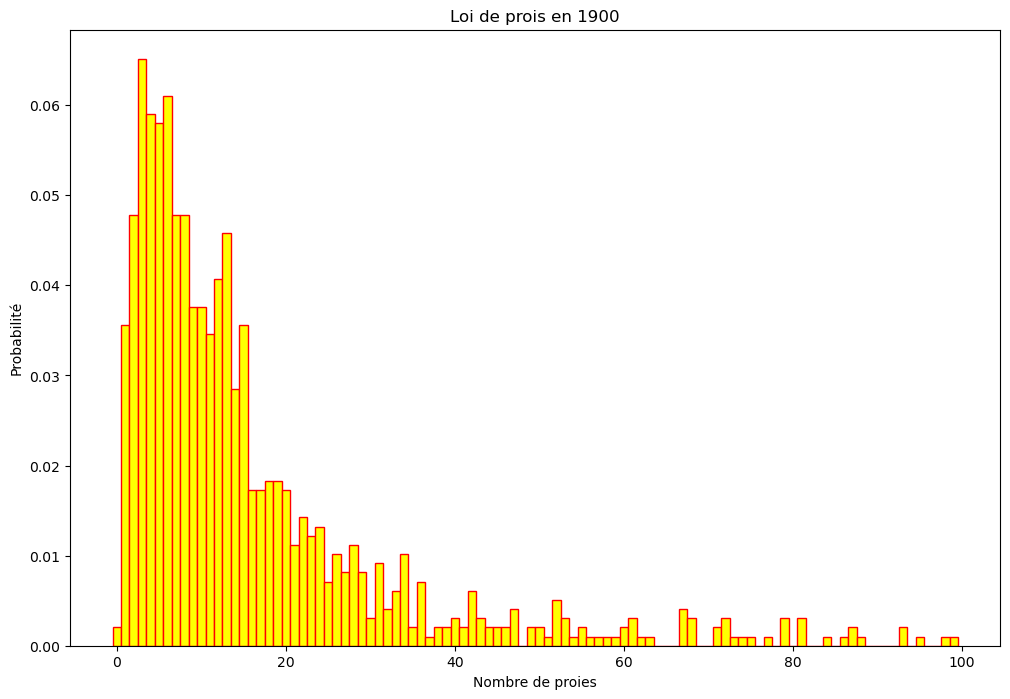

In [272]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(y0,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi de prois en 1900')
plt.show()

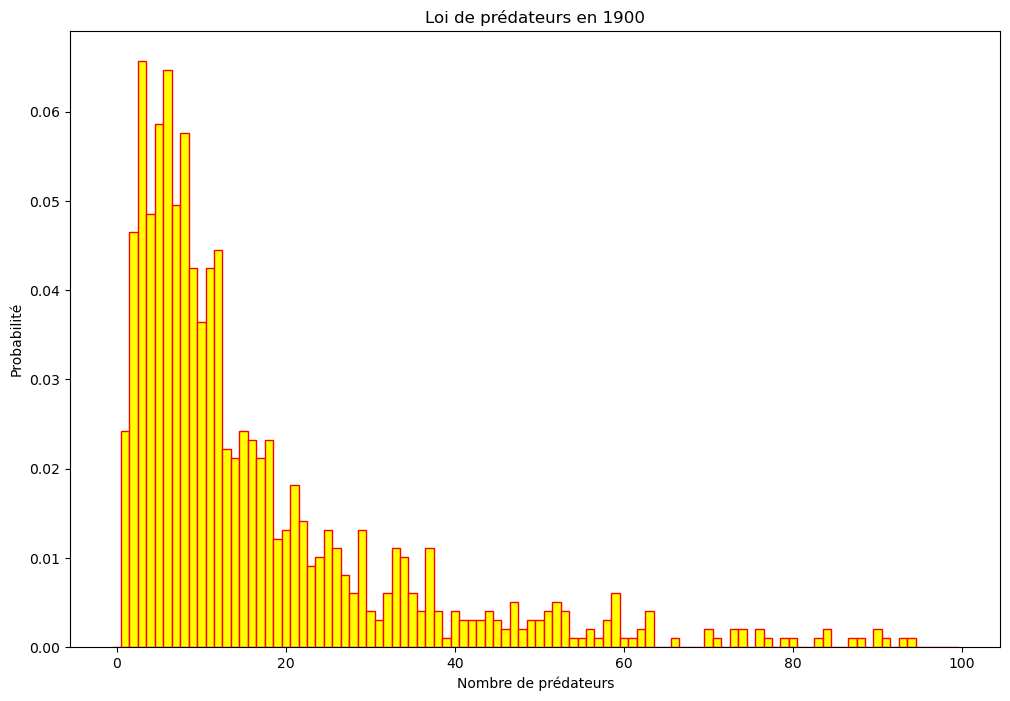

In [273]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(z0,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi de prédateurs en 1900')
plt.show()

### t1=1901

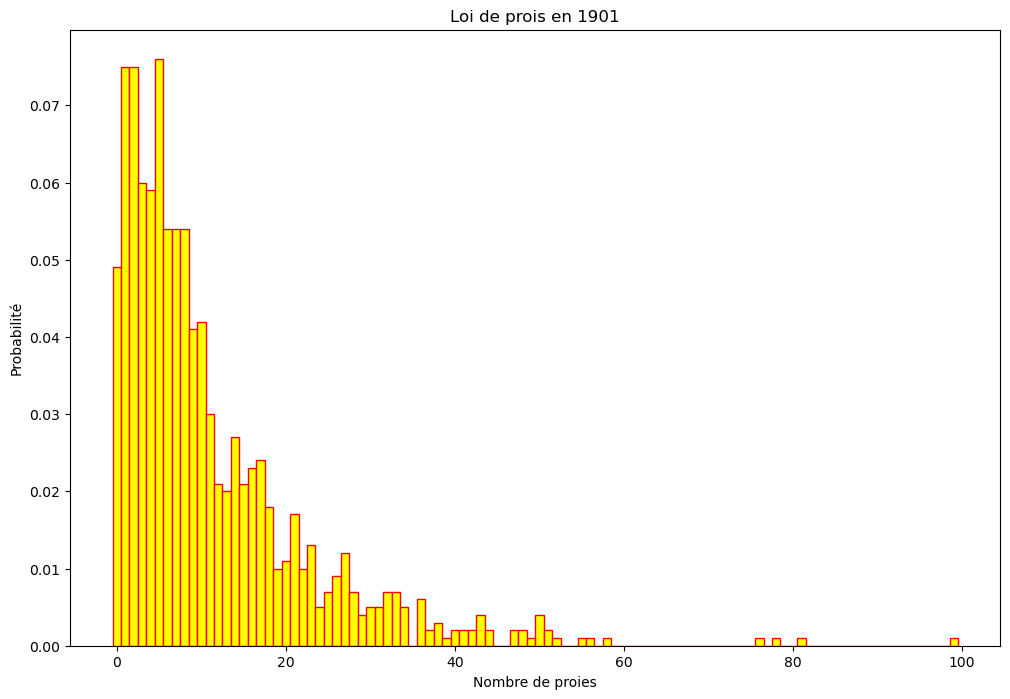

In [274]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[1][int(1/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi de prois en 1901')
plt.show()

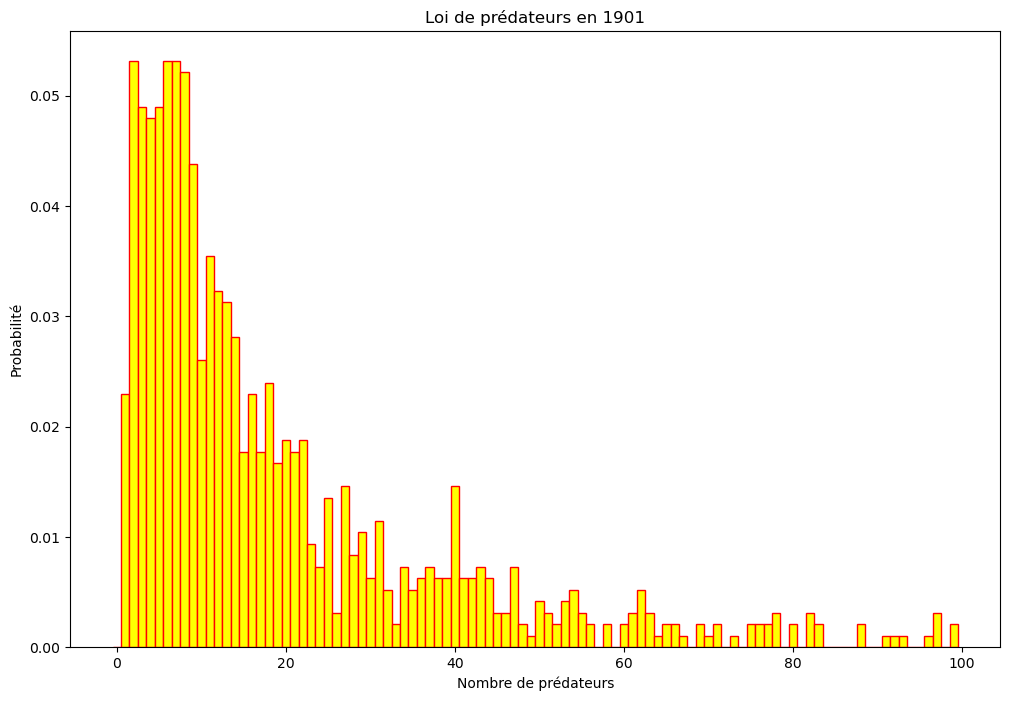

In [275]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[2][int(1/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi de prédateurs en 1901')
plt.show()

### t2=1920

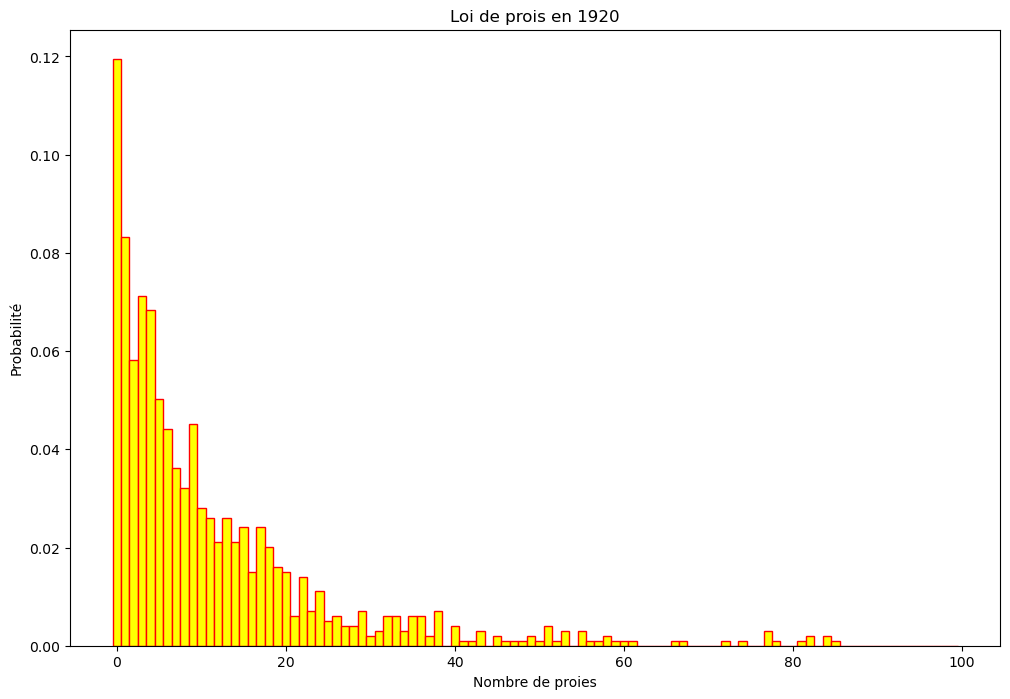

In [276]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[1][-1],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi de prois en 1920')
plt.show()

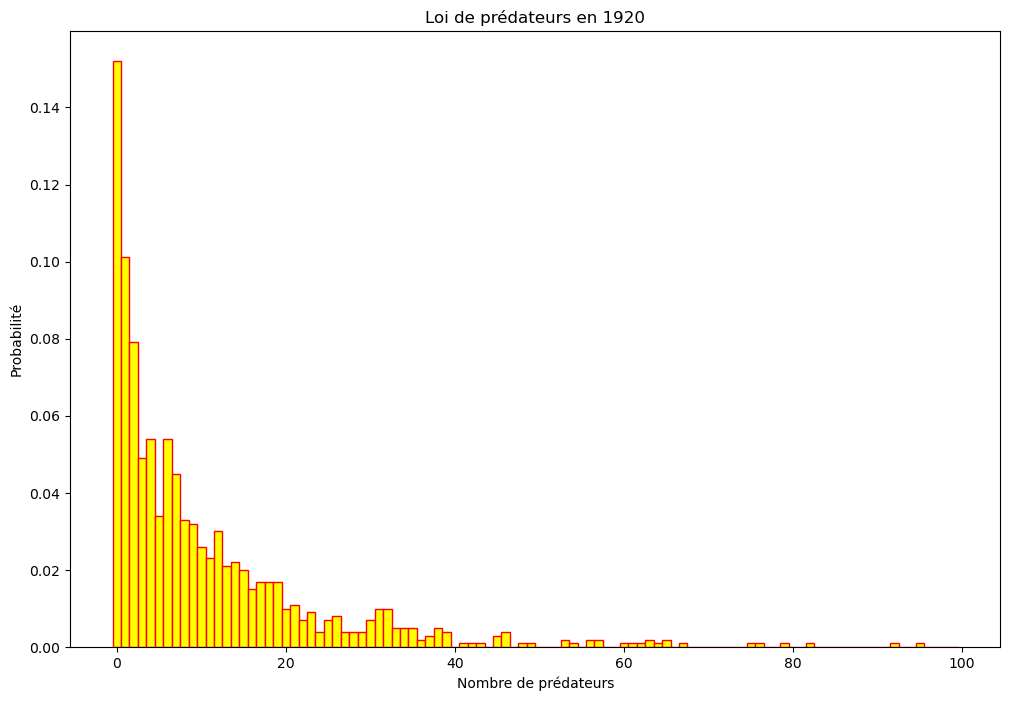

In [277]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[2][-1],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi de prédateurs en 1920')
plt.show()

### la solution moyenne de l'ED I=E(f(X)) ???

In [278]:
yto20 = [np.mean(l) for l in solution[1]]

In [279]:
zto20 = [np.mean(l) for l in solution[2]]

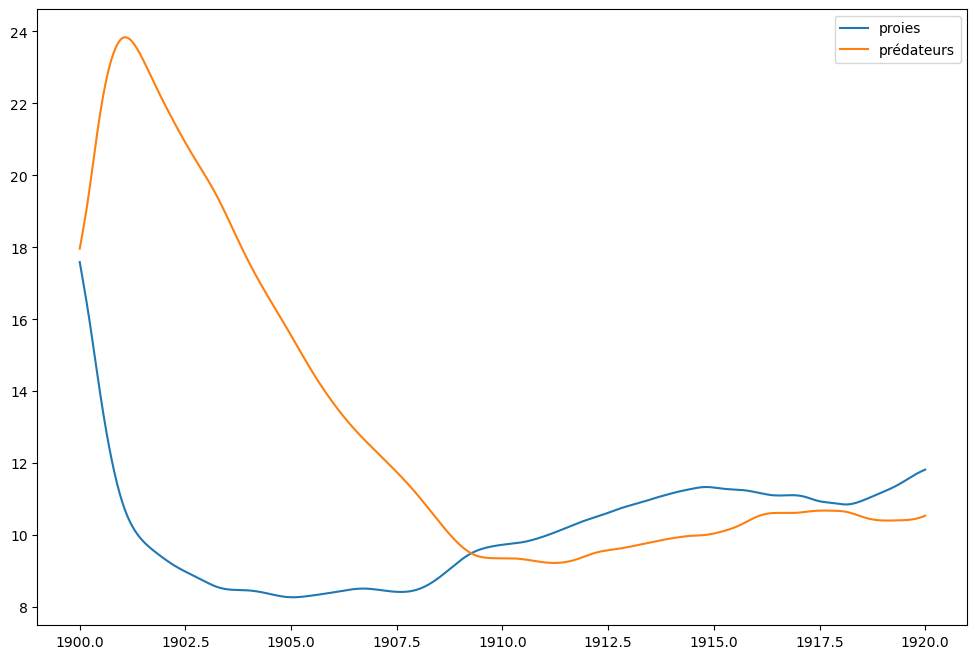

In [280]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.plot(solution[0],yto20, label ="proies")
plt.plot(solution[0],zto20, label ="prédateurs")
# plt.xlabel('Nombre de prédateurs')
# plt.ylabel('Probabilité')
# plt.title('Loi de prédateurs en 1920')
plt.legend()
plt.show()

## Q3

In [281]:
annee = [1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919,1920]
lievre = [30, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22, 25.4, 27.1, 40.3, 57, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7]
lynx = [4, 6.1, 9.8, 35.2, 59.4, 41.7, 19, 13, 8.3, 9.1, 7.4, 8, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]

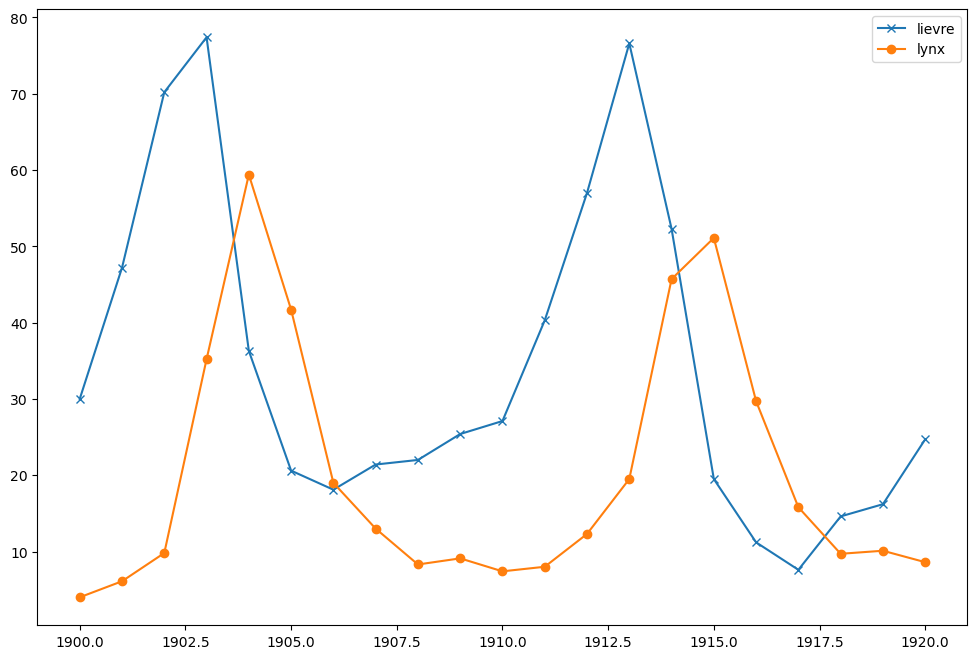

In [282]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.plot(annee,lievre,"-x", label ="lievre")
plt.plot(annee,lynx, "-o",label ="lynx")
plt.legend()
plt.show()

# 4.1 Calibration déterministe

## Q4

In [283]:
# callable
def epsilon(x,*args):
    temps,y,z = resolutionSystem1EulerRK4(x[0],x[1],x[2],x[3],x[4],x[5],args[0],args[1])
    dt = args[0]
    # print(temps[[int(k/dt) for k in range(21)]])
    ypred = y[[int(k/dt) for k in range(21)]]
    zpred = z[[int(k/dt) for k in range(21)]]
    yresidu = np.log(ypred)-np.log(args[2])
    zresidu = np.log(zpred)-np.log(args[3])
    eps = np.sum(yresidu**2)+np.sum(zresidu**2) # np.linalg.norm(objective)**2

    return eps #np.concatenate((yresidu,zresidu))


In [284]:
zeta = np.sqrt(np.log(1+(std**2)/mu**2))
lamb = np.log(mu)-(zeta**2)/2

In [285]:
x0 = [0.5,0.03,0.03,0.5,3,3]
args = (dt,N,lievre,lynx)
mean_normal = np.array([0.5, 0.05, 0.05, 0.5, np.log(10), np.log(10)])
mean_normal[:4]=lamb
std_normal = np.array([0.2, 0.02, 0.02, 0.2, 1, 1])
std_normal[:4]=zeta
min_bound = np.exp(mean_normal-2*std_normal)
max_bound = np.exp(mean_normal+2*std_normal)
bound = np.concatenate((min_bound, max_bound)).reshape((6,2), order='F')
print(bound)


[[2.14839611e-01 1.00315412e+00]
 [2.14839611e-02 1.00315412e-01]
 [2.14839611e-02 1.00315412e-01]
 [2.14839611e-01 1.00315412e+00]
 [1.35335283e+00 7.38905610e+01]
 [1.35335283e+00 7.38905610e+01]]


In [286]:
result = minimize(epsilon,x0,args=args,method="Nelder-Mead",bounds= bound) # "SLSQP","Powell"
# print(result)
print(result['fun'])
x_opt = result['x']

2.021286011424579


In [287]:
print(result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.021286011424579
             x: [ 5.397e-01  2.714e-02  2.368e-02  7.957e-01  3.482e+01
                  5.849e+00]
           nit: 696
          nfev: 1074
 final_simplex: (array([[ 5.397e-01,  2.714e-02, ...,  3.482e+01,
                         5.849e+00],
                       [ 5.397e-01,  2.714e-02, ...,  3.482e+01,
                         5.848e+00],
                       ...,
                       [ 5.397e-01,  2.714e-02, ...,  3.482e+01,
                         5.848e+00],
                       [ 5.397e-01,  2.714e-02, ...,  3.482e+01,
                         5.848e+00]]), array([ 2.021e+00,  2.021e+00,  2.021e+00,  2.021e+00,
                        2.021e+00,  2.021e+00,  2.021e+00]))


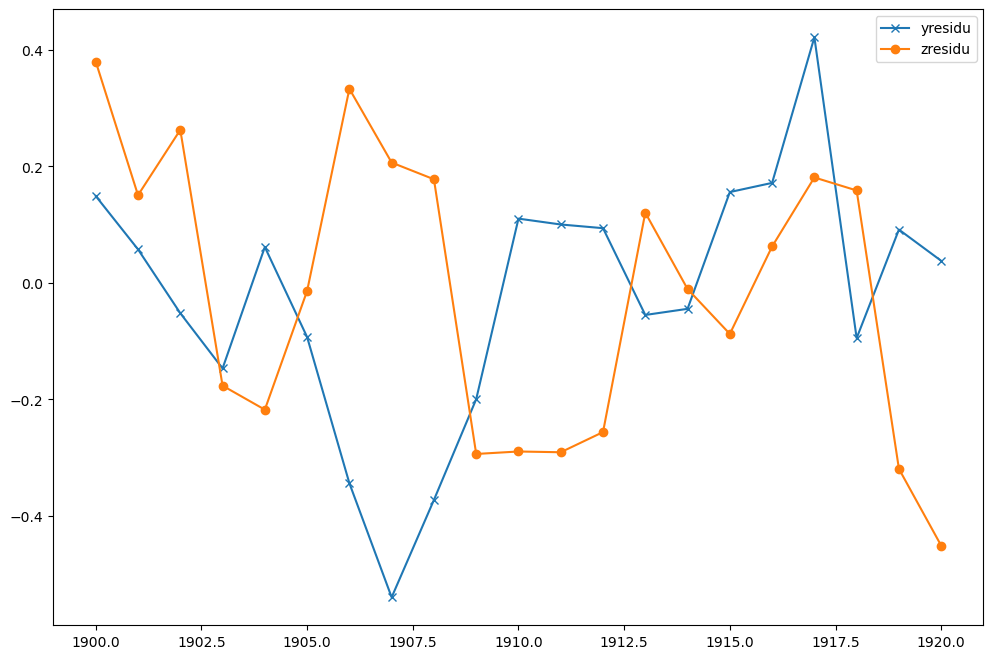

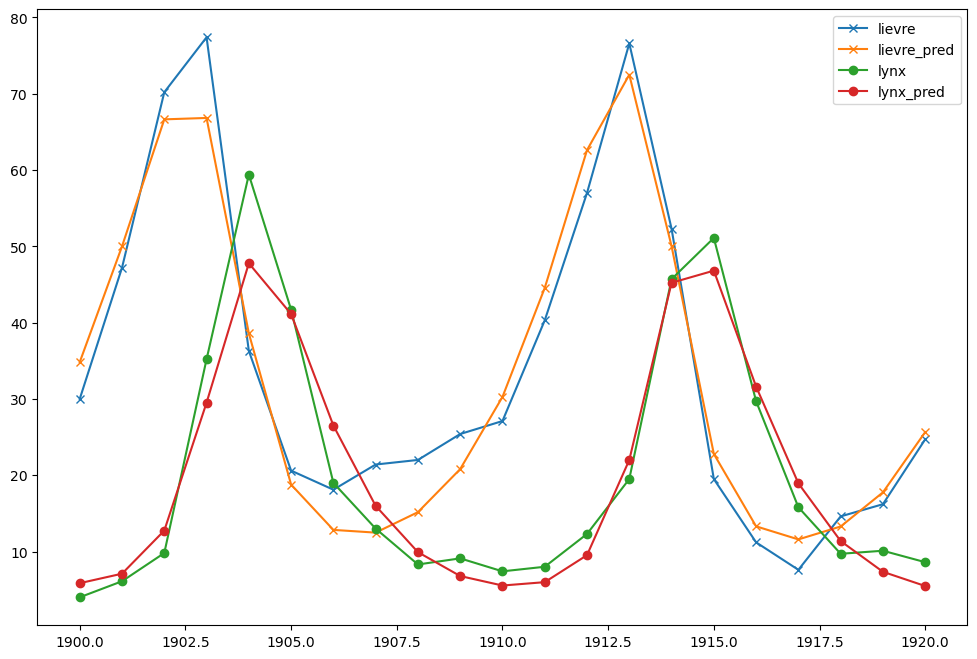

In [288]:
temps,y,z = resolutionSystem1Euler(x_opt[0],x_opt[1],x_opt[2],x_opt[3],x_opt[4],x_opt[5],args[0],args[1])
dt = args[0]
ypred = y[[int(k/dt) for k in range(21)]]
zpred = z[[int(k/dt) for k in range(21)]]
yresidu = np.log(ypred)-np.log(args[2]) # aproie
zresidu = np.log(zpred)-np.log(args[3]) # apreda

plt.figure(figsize=(12,8), facecolor='white')
plt.plot(annee,yresidu,"-x", label = "yresidu")
plt.plot(annee,zresidu, "-o",label = "zresidu")
plt.legend()
plt.show()


plt.figure(figsize=(12,8), facecolor='white')
plt.plot(annee,args[2],"-x", label = "lievre")
plt.plot(annee,ypred, "-x",label = "lievre_pred")
plt.plot(annee,args[3], "-o",label = "lynx")
plt.plot(annee,zpred,"-o",label = "lynx_pred")
plt.legend()
plt.show()

# 4.2 Calibration bayésienne

### Question 5

log=>ds 

### Question 6

 Estimation de $\sigma^{*}$

In [289]:
sigmaOptProie = np.sqrt((1/21)*np.sum(yresidu**2))
sigmaOptPredateur = np.sqrt((1/21)*np.sum(zresidu**2))

In [290]:
def vraisemblance(x, sigmaProie, sigmaPredateur):
    global args
    temps,y,z = resolutionSystem1Euler(x[0],x[1],x[2],x[3],x[4],x[5],args[0],args[1])
    dt = args[0]
    ypred = y[[int(k/dt) for k in range(21)]]
    zpred = z[[int(k/dt) for k in range(21)]]
    yresidu = np.log(ypred)-np.log(args[2]) # aproie
    zresidu = np.log(zpred)-np.log(args[3]) # apreda
    p = np.sqrt(((2*np.pi)**21)*(sigmaProie**21)*(sigmaPredateur**21))
    e_proie2 = np.sum(yresidu**2)
    e_preda2 = np.sum(zresidu**2)
    p=(1/p)*np.exp(-0.5*(e_proie2/(sigmaProie**2)+e_preda2/(sigmaPredateur**2)))
    
    return p

In [291]:
def prior(x):
    global mean_normal 
    global std_normal
    p=1
    for i in range(np.size(x)):
        p = p*lognorm.pdf(x=x[i], s=std_normal[i], scale=np.exp(mean_normal[i])) #  les paramètres sont indépendants
    
    return p

In [292]:
# test 
vraisemblance(x_opt, sigmaOptProie, sigmaOptPredateur)

0.00012490838818973943

In [293]:
def  posteriori(x,sigmaProie, sigmaPredateur):
    p = vraisemblance(x, sigmaProie, sigmaPredateur)*prior(x)
    
    return p
    

In [294]:
# test 
posteriori(x_opt, sigmaOptProie, sigmaOptPredateur)

4.638499746255545e-06

In [295]:
lognorm_dist = lognorm(s = 10000, scale=100)

# Compute the PDF of the log-normal distribution at x
pdf = lognorm_dist.pdf(0.0001)    #.     ????????????????????????????,
print(pdf)

0.39894189967437627


## Algorithme de Metropolis-Hastings

In [458]:
def MetropolisHastings(x0,Nsamples,sigmaOptProie,sigmaOptPredateur):
    L=[]
    x = x0
    for i in range(Nsamples):
        xprim = np.random.multivariate_normal(x,np.identity(np.size(x0)), size=1)
        xprim.shape=(np.size(x0),)
        ro = posteriori(np.array(xprim), sigmaOptProie, sigmaOptPredateur)/posteriori(x, sigmaOptProie, sigmaOptPredateur)
        u = np.random.uniform()
        a=min([1,ro])
        
        if(u<=a):
            x = xprim
        L.append(x)
    return np.array(L)
    

In [459]:
## test 
Nsamples =10000
b =100
SamplesXpost = MetropolisHastings(x_opt,Nsamples ,sigmaOptProie, sigmaOptPredateur)
SamplesXpost = SamplesXpost[b:,]  ## nous ne prenons pas en compte les 100 premiers échantillons donnés par MH
# Nsamples = Nsamples-100

/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:7: RuntimeWarning: overflow encountered in double_scalars
  y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:8: RuntimeWarning: overflow encountered in double_scalars
  z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/432350801.py:7: RuntimeWarning: invalid value encountered in log
  yresidu = np.log(ypred)-np.log(args[2]) # aproie
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/432350801.py:8: RuntimeWarning: invalid value encountered in log
  zresidu = np.log(zpred)-np.log(args[3]) # apreda
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/423883615.py:7: RuntimeWarning: invalid value encountered in double_scalars
  ro = posteriori(np.array(xprim), sigmaOptProie, sigmaOptPredateur)/posteriori(x, sigmaOptProie, sigmaOptPredateur)


 nous ne prenons pas en compte les 100 premiers échantillons donnés par l'algorithme de Metropolis-Hastings

In [460]:
alphaPost = SamplesXpost[:,0]
betaPost = SamplesXpost[:,1]
deltaPost = SamplesXpost[:,2]
gammaPost = SamplesXpost[:,3]
y0Post = SamplesXpost[:,4]
z0Post = SamplesXpost[:,5]

In [461]:
bins = [x+ 0.5 for x in range(-1, 100)]

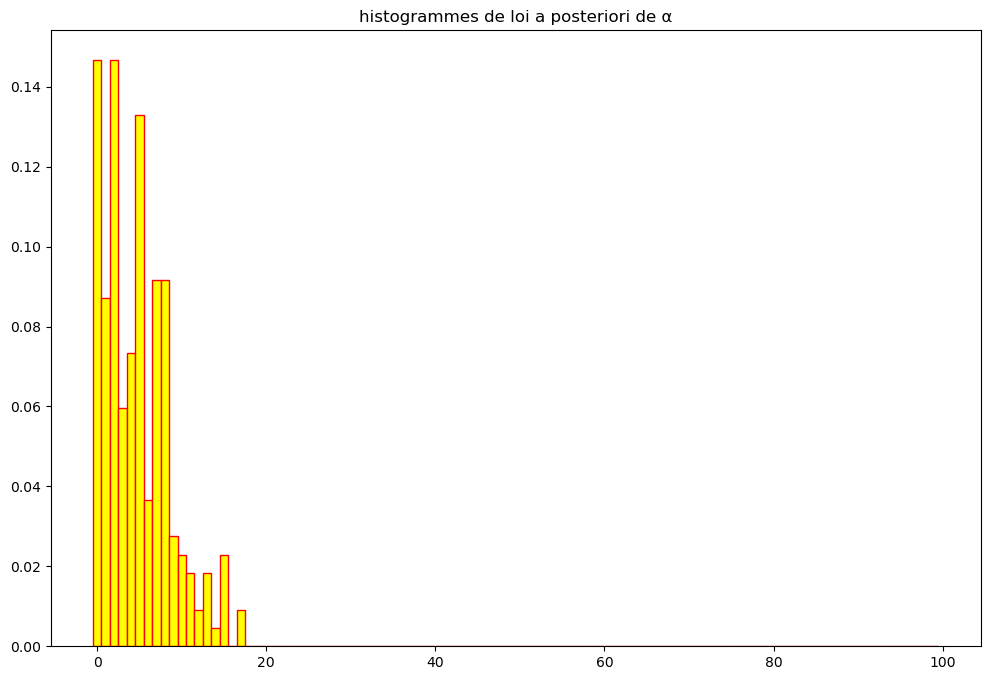

In [462]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(alphaPost,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de α')
plt.show()

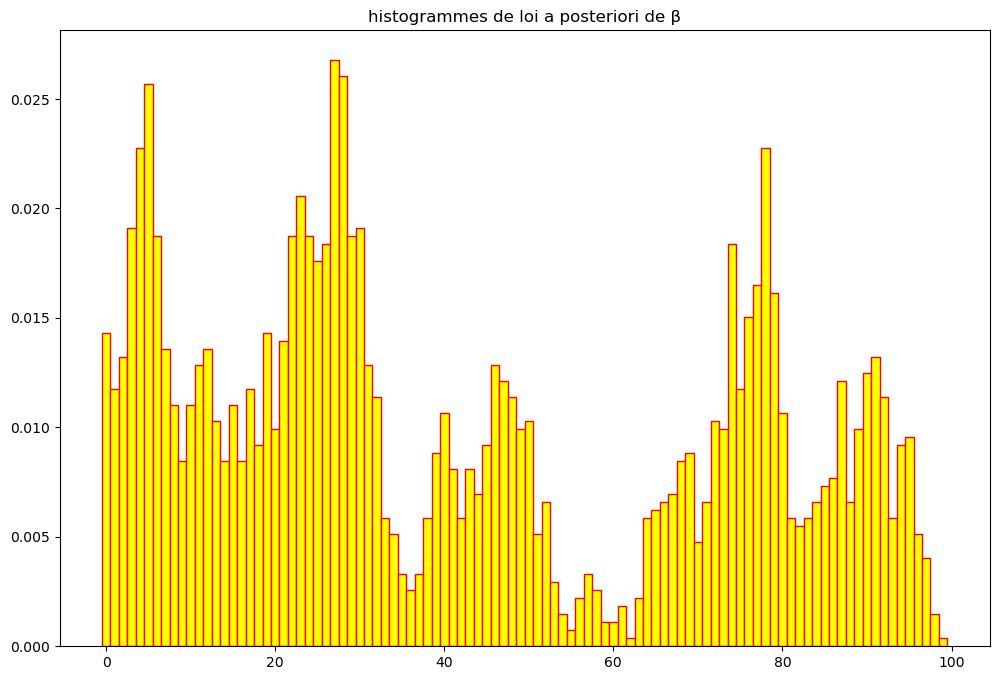

In [463]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(betaPost,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de β')
plt.show()

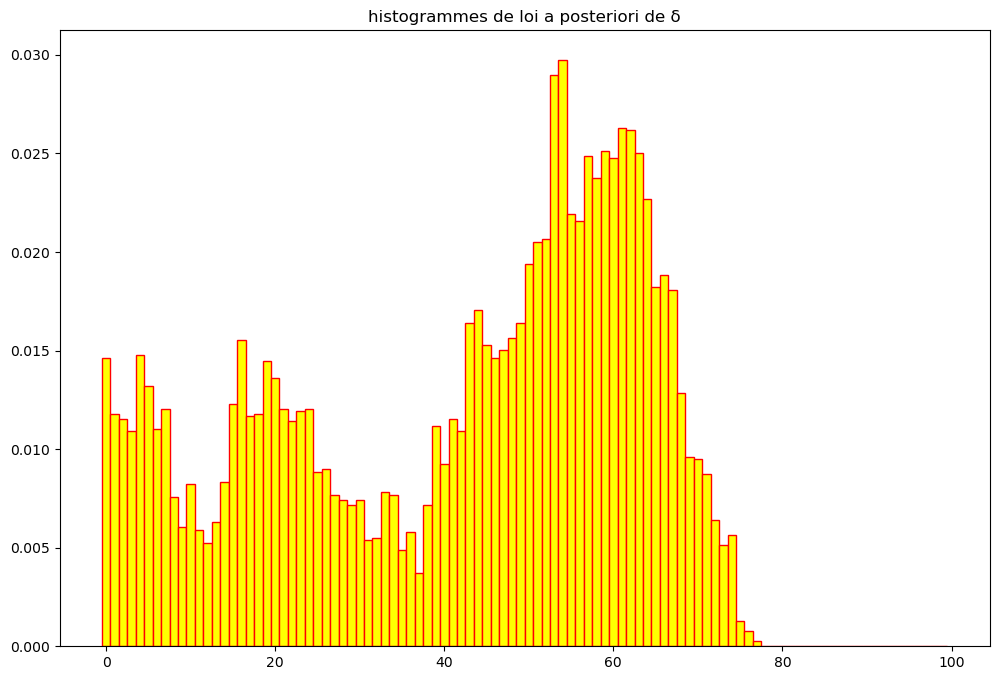

In [464]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(deltaPost,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de δ')
plt.show()

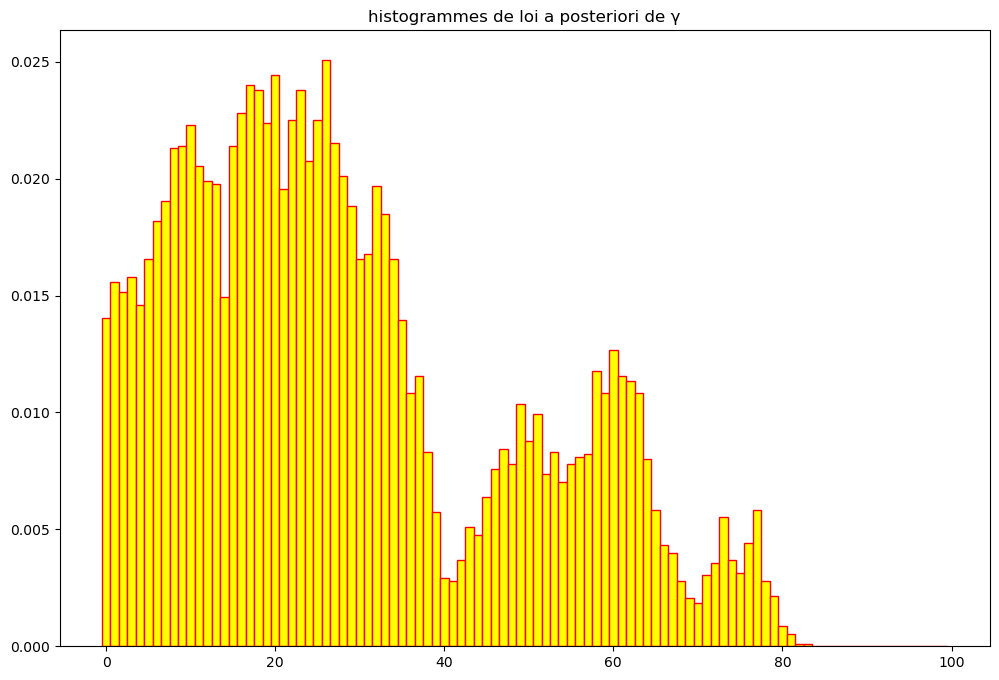

In [465]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(gammaPost,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de γ')
plt.show()

##### verification sur y0 et z0

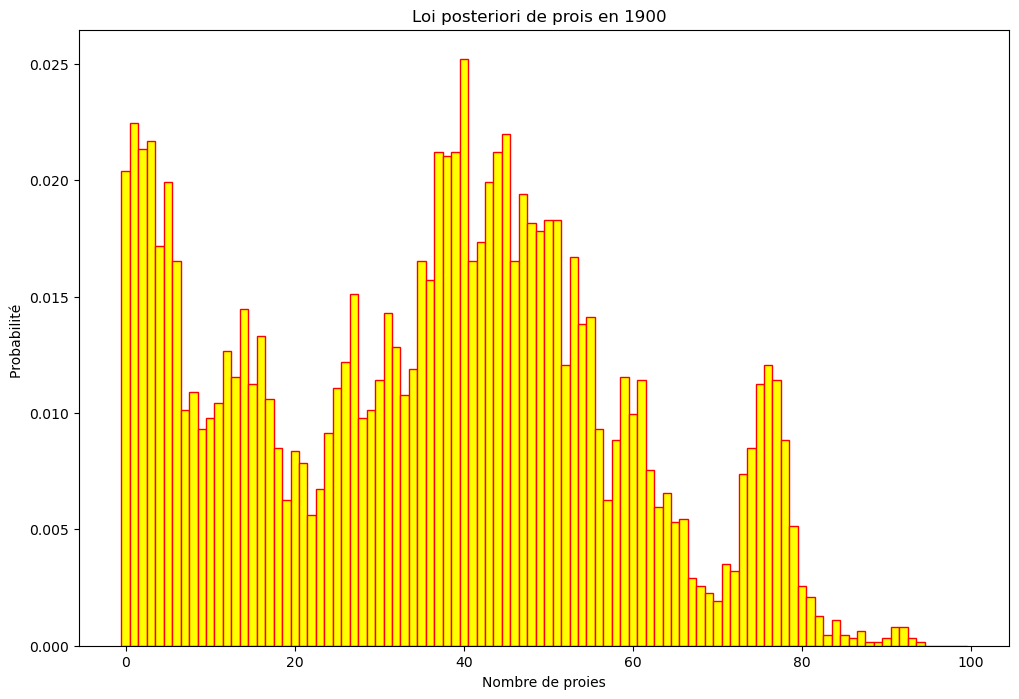

In [466]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(y0Post,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité ')
plt.title('Loi posteriori de prois en 1900  ')
plt.show()

conforme bien avec les données t0=0 ????

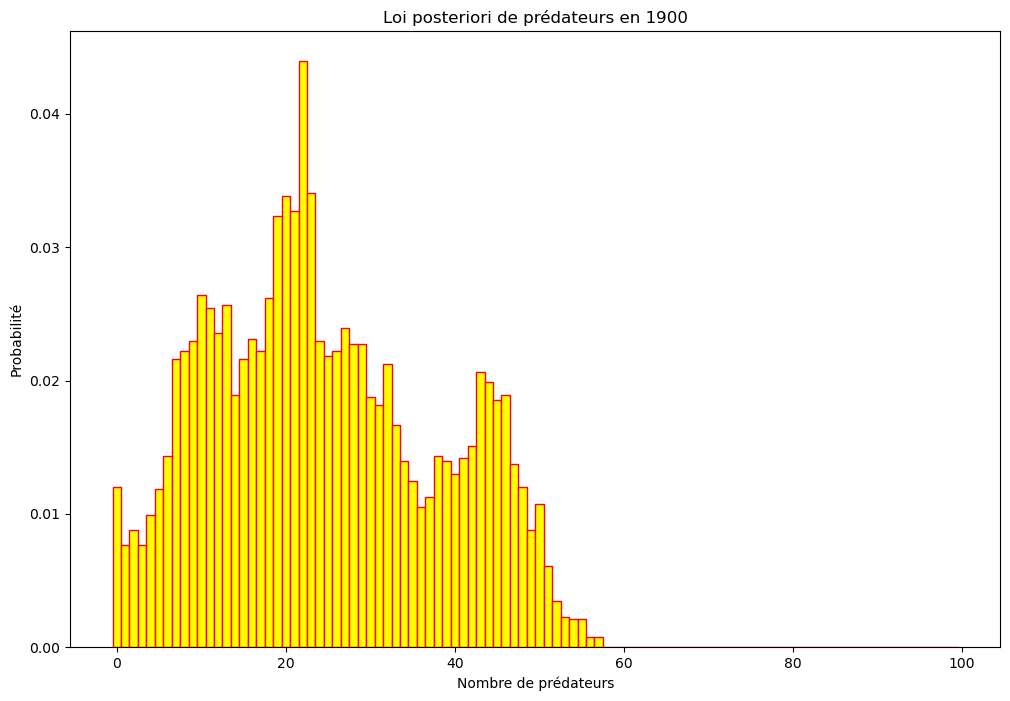

In [467]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(z0Post,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1900')
plt.show()

In [468]:
N=Nsamples-b
dt = 30/(N-1) # pour trouver l'indice de l'année k=année/dt
solution = resolutionSystem1Euler(alphaPost,betaPost,deltaPost,gammaPost,y0Post,z0Post,dt,N)

/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:7: RuntimeWarning: overflow encountered in multiply
  y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:8: RuntimeWarning: overflow encountered in multiply
  z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))


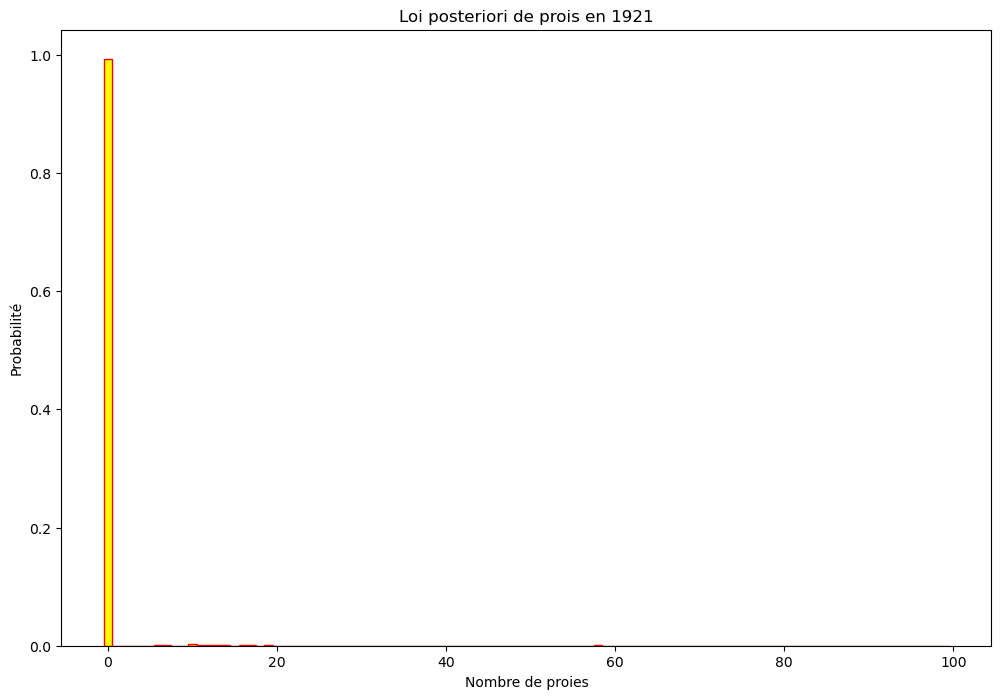

In [469]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[1][int(21/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prois en 1921')
plt.show()

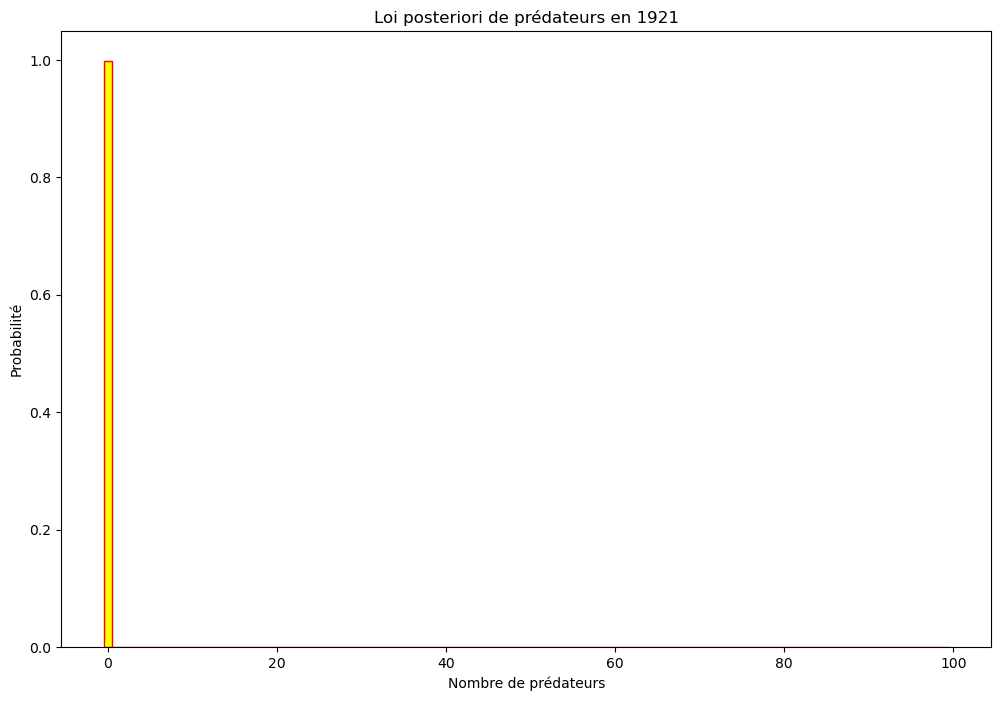

In [470]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[2][int(21/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1921')
plt.show()

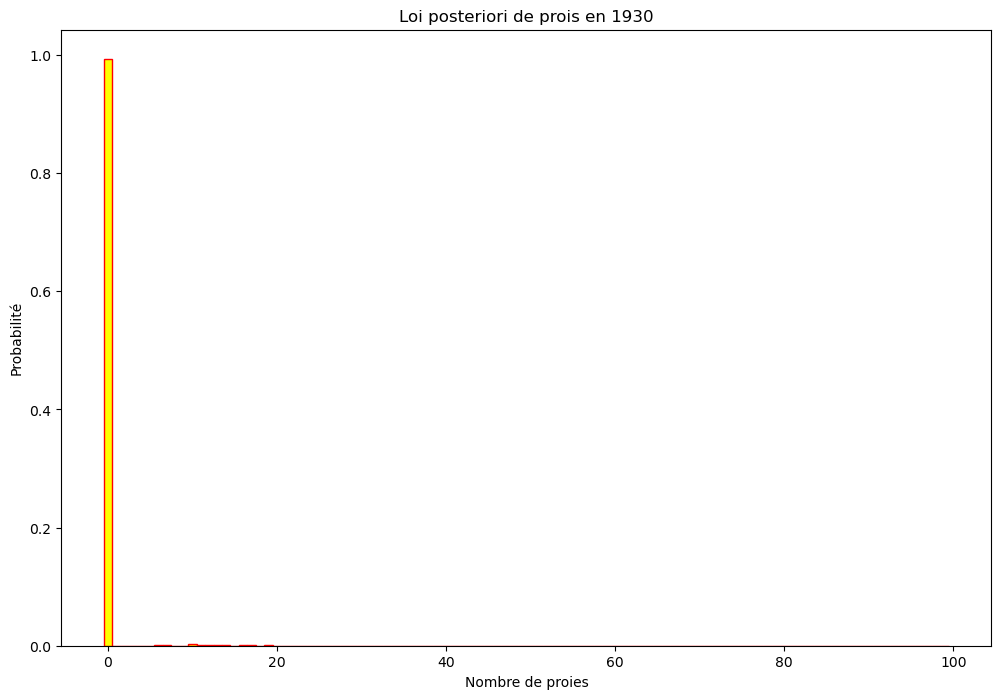

In [471]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[1][int(30/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prois en 1930')
plt.show()

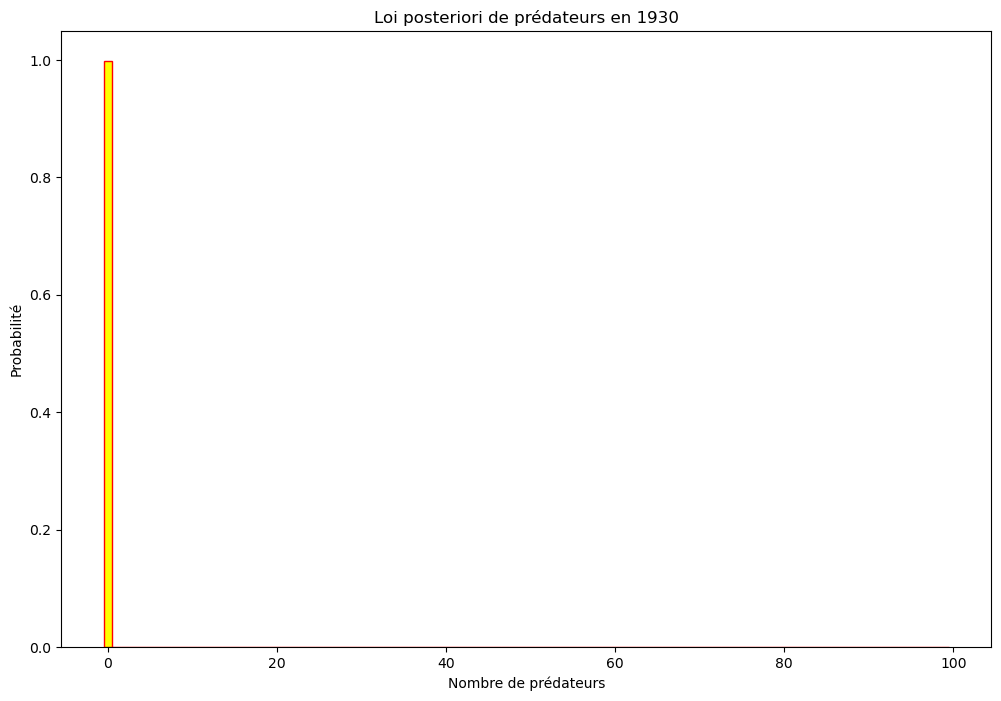

In [472]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[2][int(30/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1930')
plt.show()


### 4.3 Calibration full-bayésienne

#### Question 7

In [474]:
def fullPosteriori(x,sigmaProie, sigmaPredateur):
    P1 = lognorm.pdf(x=x[6], s=-1, scale=np.exp(1))
    P2 = lognorm.pdf(x=x[7], s=-1, scale=np.exp(1))
    p = vraisemblance(x[:6,], sigmaProie, sigmaPredateur)*prior(x[:6,])*P1*P2
    
    return p

In [475]:
def MetropolisHastingsFull(x0,Nsamples,sigmaOptProie,sigmaOptPredateur):
    L=[]
    x = x0
    for i in range(Nsamples):
        xprim = np.random.multivariate_normal(x,np.identity(np.size(x0)), size=1)
        xprim.shape=(np.size(x0),)
        ro = fullPosteriori(np.array(xprim), sigmaOptProie, sigmaOptPredateur)/fullPosteriori(x, sigmaOptProie, sigmaOptPredateur)
        u = np.random.uniform()
        a=min([1,ro])
        
        if(u<=a):
            x = xprim
        L.append(x)
    return np.array(L)

In [478]:
x0 = np.concatenate((x_opt,np.array([np.exp(-1),np.exp(-1)])))

(8,)


In [482]:
## test 
Nsamples =10000
b =100
SamplesXpostFull = MetropolisHastingsFull(x0,Nsamples ,sigmaOptProie, sigmaOptPredateur)
SamplesXposFull = SamplesXpostFull[b:,]  ## 

/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:7: RuntimeWarning: overflow encountered in double_scalars
  y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:8: RuntimeWarning: overflow encountered in double_scalars
  z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/432350801.py:7: RuntimeWarning: invalid value encountered in log
  yresidu = np.log(ypred)-np.log(args[2]) # aproie
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/432350801.py:8: RuntimeWarning: invalid value encountered in log
  zresidu = np.log(zpred)-np.log(args[3]) # apreda


In [483]:
alphaPostFull = SamplesXpostFull[:,0]
betaPostFull = SamplesXpostFull[:,1]
deltaPostFull = SamplesXpostFull[:,2]
gammaPostFull = SamplesXpostFull[:,3]
y0PostFull = SamplesXpostFull[:,4]
z0PostFull = SamplesXpostFull[:,5]

In [485]:
bins = [x+ 0.5 for x in range(-1, 100)]

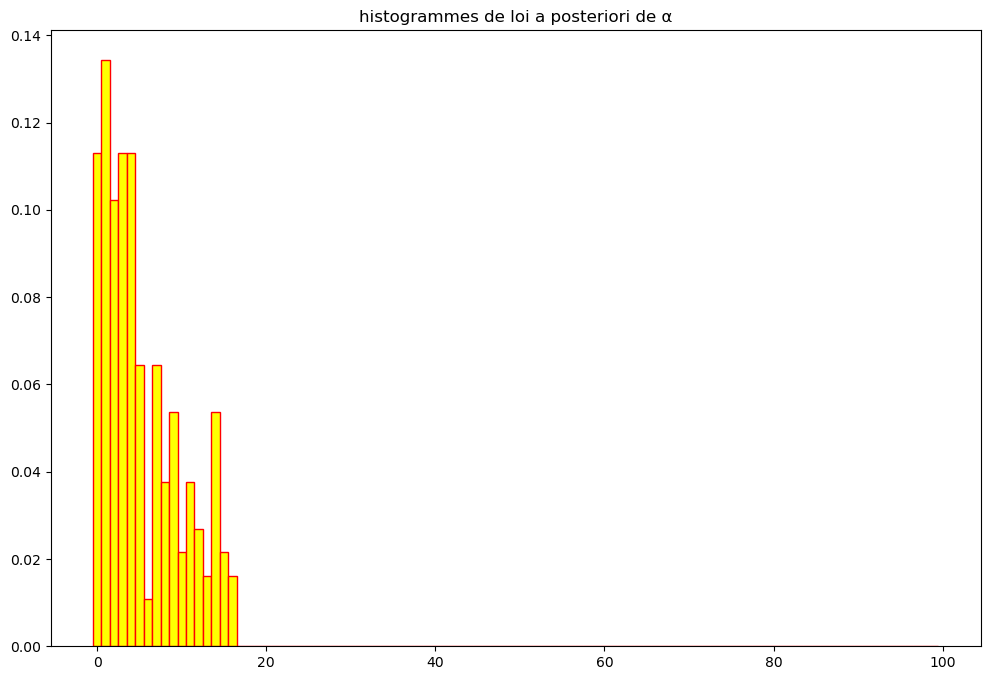

In [488]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(alphaPostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de α')
plt.show()

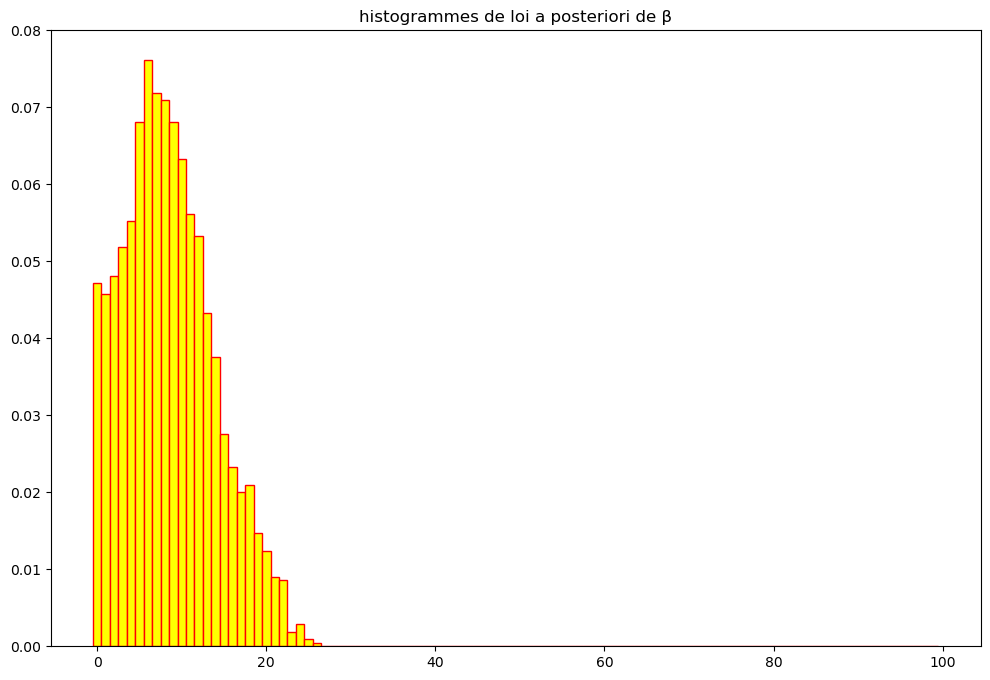

In [489]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(betaPostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de β')
plt.show()

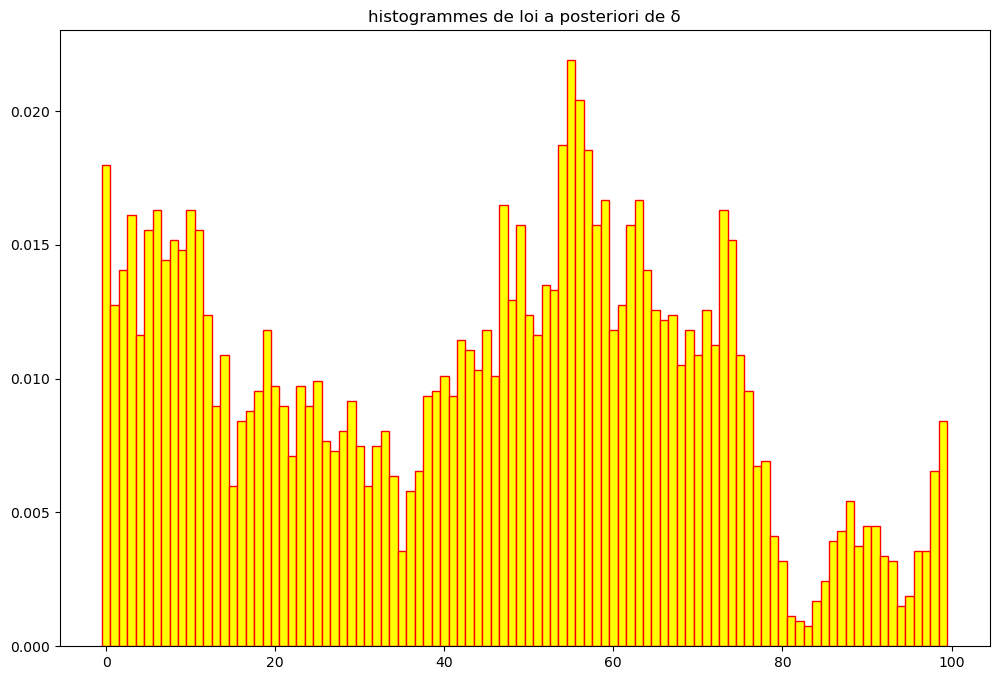

In [490]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(deltaPostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de δ')
plt.show()

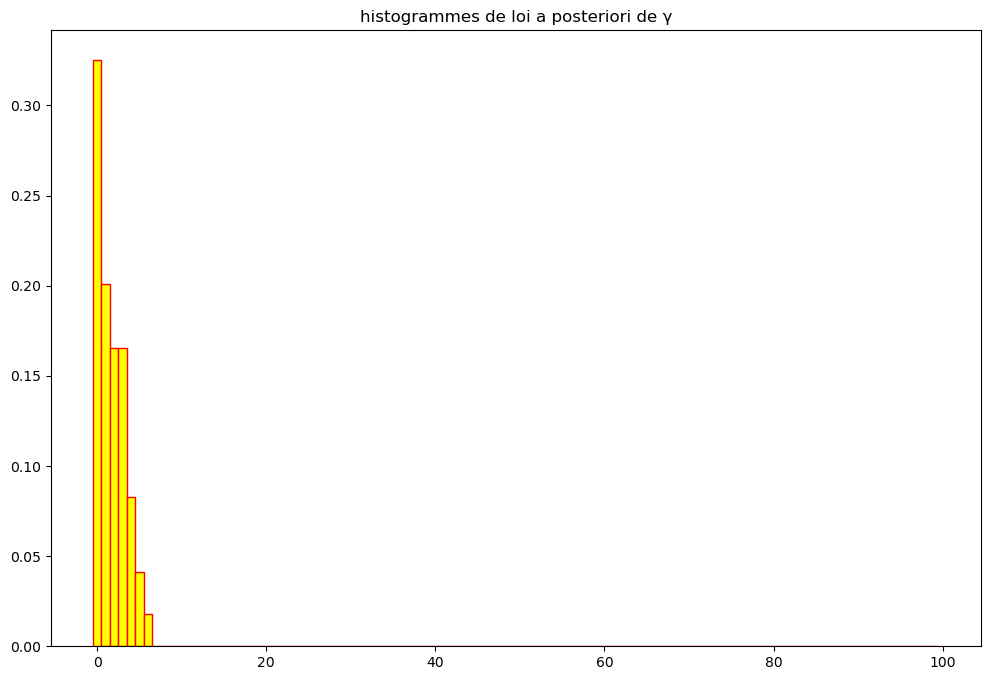

In [491]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(gammaPostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de γ')
plt.show()

##### verification sur y0 et z0

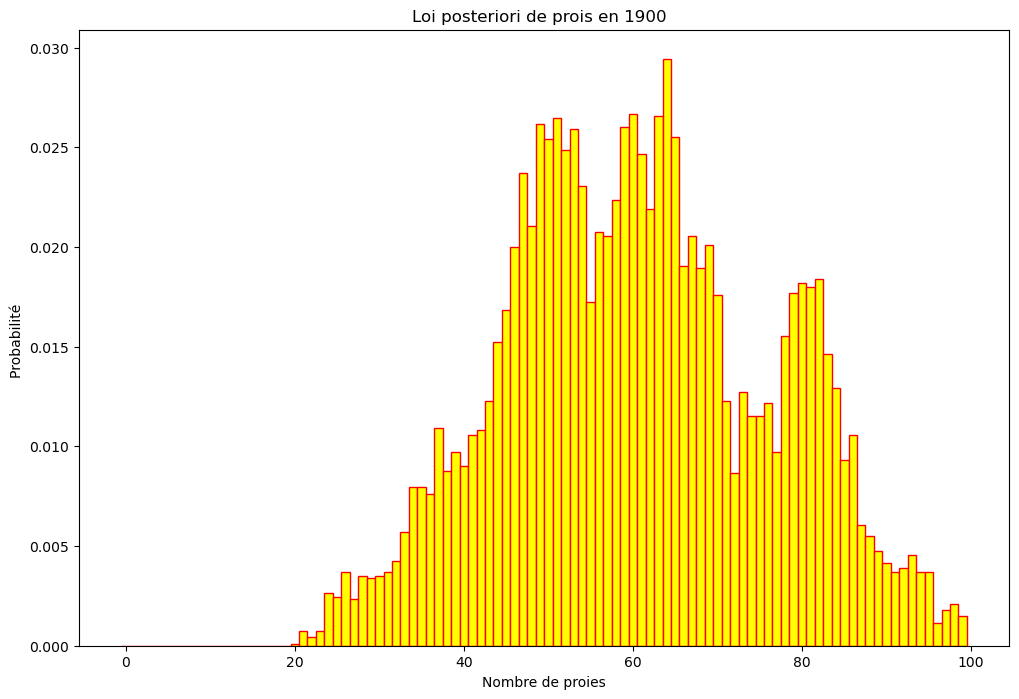

In [492]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(y0PostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité ')
plt.title('Loi posteriori de prois en 1900  ')
plt.show()

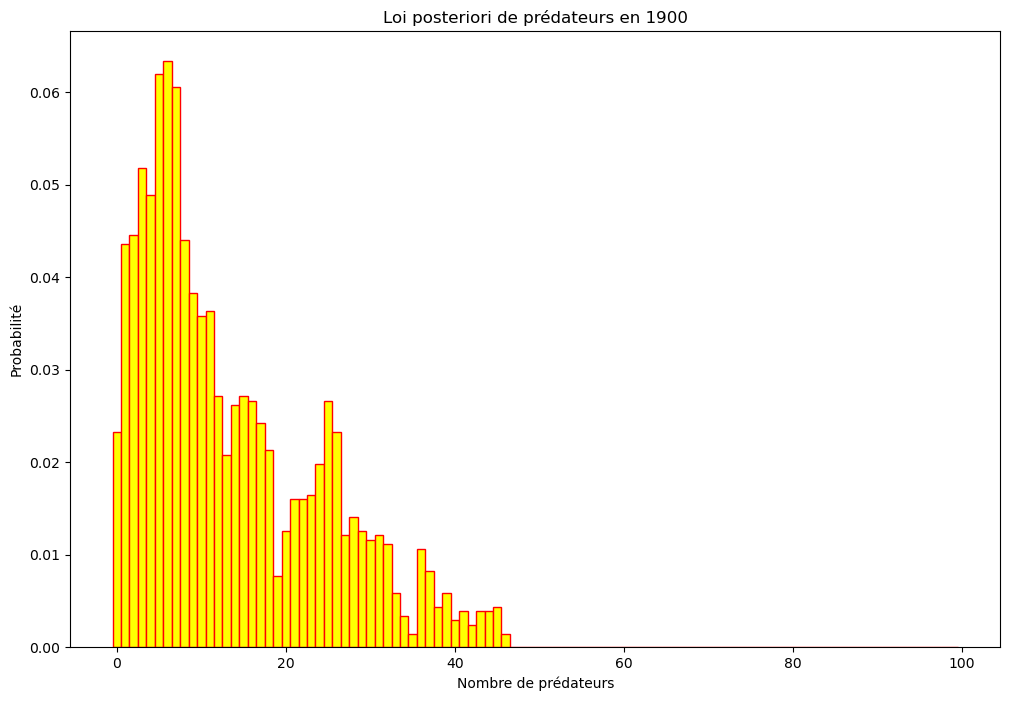

In [493]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(z0PostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1900')
plt.show()

In [496]:
N=Nsamples-b
dt = 30/(N-1) # pour trouver l'indice de l'année k=année/dt
solutionFull = resolutionSystem1Euler(alphaPostFull,betaPostFull,deltaPostFull,gammaPostFull,y0PostFull,z0PostFull,dt,N)

/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:7: RuntimeWarning: overflow encountered in multiply
  y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:8: RuntimeWarning: overflow encountered in multiply
  z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))


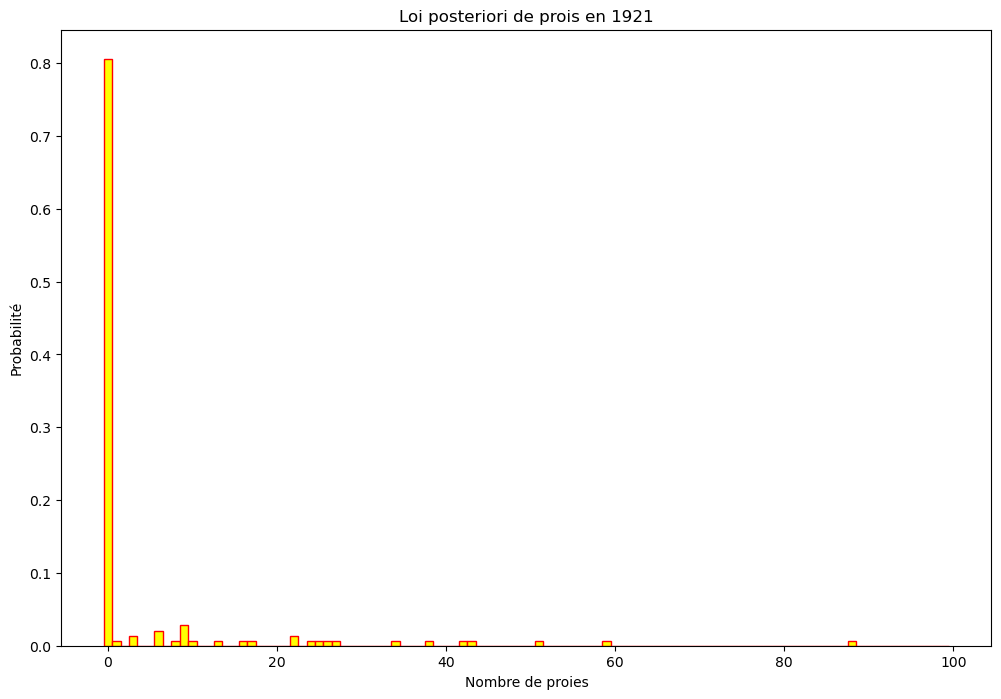

In [497]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solutionFull[1][int(21/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prois en 1921')
plt.show()

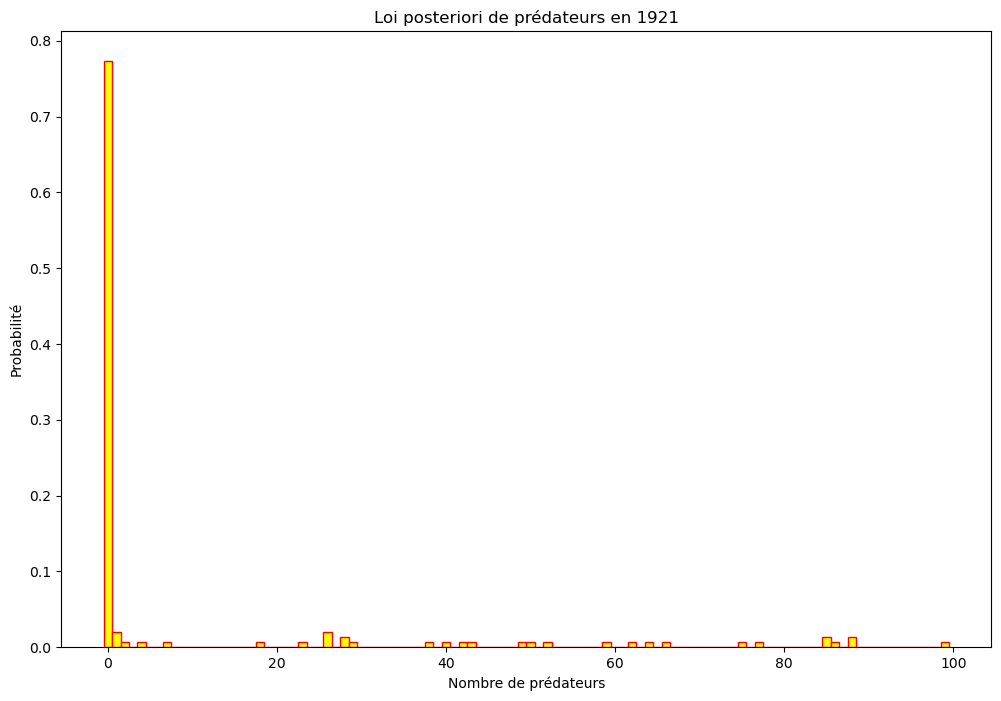

In [498]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solutionFull[2][int(21/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1921')
plt.show()

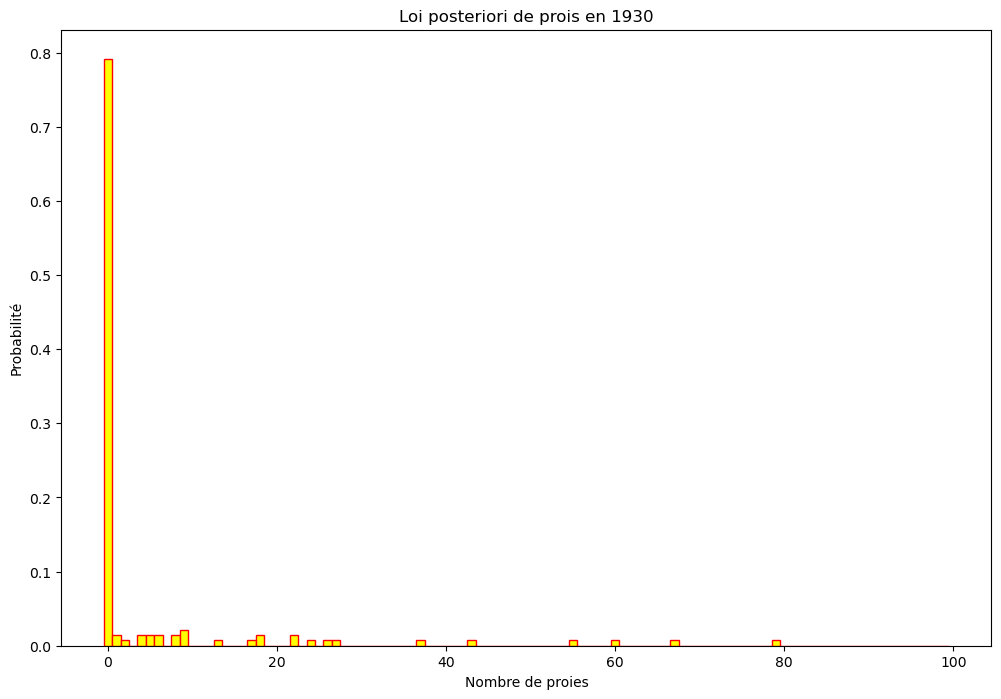

In [499]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solutionFull[1][int(30/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prois en 1930')
plt.show()

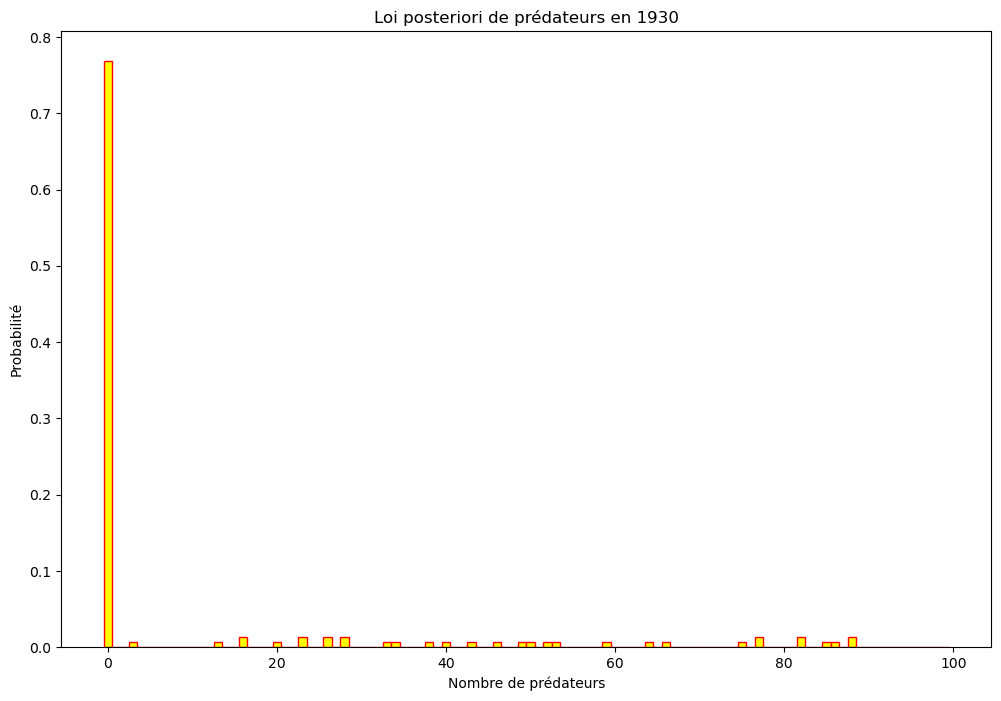

In [500]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solutionFull[2][int(30/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1930')
plt.show()